Импорт бибиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


ModuleNotFoundError: No module named 'pandas'

# Загрузка данных


In [ ]:
# Загрузка данных
financial_data = pd.read_csv("financial_data.csv", sep=",")
prolongations = pd.read_csv("prolongations.csv", sep=",")

# Удалим пробелы в названиях столбцов
financial_data.columns = financial_data.columns.str.strip()
prolongations.columns = prolongations.columns.str.strip()

# Преобразуем данные
удалим некорректные значения

In [ ]:
month_cols = financial_data.columns[2:-1]  # исключаем 'id', 'Причина дубля', 'Account'

# Все мусорные значения, которые не поддаются преобразованию в числа
bad_values = ["стоп", "в ноль", "nan", "нет", "", "end"]

for col in month_cols:
    financial_data[col] = (
        financial_data[col]
        .astype(str)
        .str.lower()                      # унификация регистра
        .str.strip()                      # удаление лишних пробелов
        .str.replace("\u00a0", "", regex=False)  # удаление неразрывного пробела
        .str.replace(",", ".", regex=False)      # замена запятой на точку
        .replace(bad_values, "0", regex=False)   # замена мусорных значений на 0
        .astype(float)                   # преобразование в число
    )


# Уберем дубликаты
например в исходном файле есть дубликаты строк с одинаковыми id и Account, есть строки которые описывают частичную оплату по одному и тому же id, для удобства просуммируем все значения по месяцам, чтоб получить итоговую сумму 

## Преобразование в длинный формат 
данное действие удобнее для анализа, расчетов коэффициентов и фильрации значения

In [ ]:

# Группируем, чтобы убрать дубли по id+Account
fin_grouped = financial_data.groupby(["id", "Account"])[month_cols].sum().reset_index()

# Преобразуем в длинный формат
fin_melted = fin_grouped.melt(id_vars=["id", "Account"], var_name="month", value_name="shipment")
fin_melted["shipment"] = fin_melted["shipment"].fillna(0)
fin_melted["month"] = fin_melted["month"].str.lower().str.strip()

# Приводим 'month' из prolongations к нижнему регистру
prolongations["month"] = prolongations["month"].str.lower().str.strip()

# Объединение
Объединяем таблицы fin_melted, преобразованную выше, и prolongations по общему столбцу id.





In [ ]:
# Объединение
merged = fin_melted.merge(prolongations, on="id", suffixes=('_shipment', '_prolongation'))

### Перевод
Позволяет преобразовать строку "март 2023" в числовой формат 03.2023, который можно превратить в дату (pd.Timestamp)

In [ ]:
# Словарь для перевода месяцев
month_mapping = {
    "январь": 1, "февраль": 2, "март": 3, "апрель": 4, "май": 5,
    "июнь": 6, "июль": 7, "август": 8, "сентябрь": 9, "октябрь": 10,
    "ноябрь": 11, "декабрь": 12
}

### Добавление дат 
Добавляет 2 новых столбца с датами типа datetime64, а не просто текстом:

**prolongation_date** — дата пролонгации
**shipment_date** — дата отгрузки

In [ ]:
# Функция для преобразования "месяц год" → pd.Timestamp
def parse_month_year(m):
    try:
        parts = m.split()
        month = month_mapping.get(parts[0])
        year = int(parts[1])
        return pd.Timestamp(year=year, month=month, day=1)
    except:
        return pd.NaT

# Преобразуем оба месяца
merged["prolongation_date"] = merged["month_prolongation"].apply(parse_month_year)
merged["shipment_date"] = merged["month_shipment"].apply(parse_month_year)

**pd.to_numeric()**	Преобразует строки в числа	*Для корректных вычислений* <br>
**merged[... > 0]**	Фильтрует строки с ненулевой *отгрузкой	Чтобы анализировать только реальные отгрузки* <br>
**month_diff**	Считает количество месяцев между пролонгацией и отгрузкой	*Для расчёта метрик активности клиента* <br>

In [ ]:
# Приводим 'shipment' к числу
merged["shipment"] = pd.to_numeric(merged["shipment"], errors="coerce").fillna(0)

# Оставляем только отгрузки > 0
merged = merged[merged["shipment"] > 0]

# Вычисляем смещение месяцев между пролонгацией и отгрузкой
merged["month_diff"] = ((merged["shipment_date"].dt.year - merged["prolongation_date"].dt.year) * 12 +
                        (merged["shipment_date"].dt.month - merged["prolongation_date"].dt.month))


# Функция расчета коэффициентов

**Коэффициент 1** показывает: какая доля отгрузки пришлась на 1 месяц после пролонгации <br>
**Коэффициент 2** показывает: какая доля отгрузки пришлась на 2 месяц после пролонгации, если не было отгрузки в 1 месяц<br>

## Расчет коэффициента 1 - Это доля клиентов, которые отгрузились через 1 месяц после пролонгации

**base1**: все строки, где пролонгация была в предыдущем месяце<br>
**shipped1**: из них — те, где отгрузка пришлась на текущий месяц<br>
**coef1_total**: сумма отгрузок в текущем месяце ÷ сумма пролонгированных договоров в предыдущем <br>

## Расчет коэффициента 2 - Это доля клиентов, которые отгрузились через 1 месяц после пролонгации

**base2**: Берём договоры, пролонгированные 2 месяца назад<br>
**prev1_shipped_ids**: Ищем среди них те, кто уже отгрузился в прошлом месяце (1 месяц после пролонгации). Сохраняем их id, чтобы исключить<br>
**base2_filtered**: Исключаем тех, кто уже отгрузился на первом месяце. Оставляем только «запаздывающих» <br>
**shipped2**: Из оставшихся отбираем тех, кто отгрузился во втором месяце после пролонгации<br>
**coef2_total**: Считаем коэффициент: доля пролонгированных, которые не отгрузились в 1 месяц, но отгрузились во 2. <br>


*Сохраняем результат*



In [ ]:
# ---------- 8. Функция расчёта коэффициентов ----------
def calculate_coefficients(df):
    results = []

    for period in sorted(df["shipment_month_str"].unique()):
        current_month = pd.Period(period, freq="M")
        prev_month = current_month - 1
        prev2_month = current_month - 2

        # Коэффициент 1
        base1 = df[df["prolongation_date"].dt.to_period("M") == prev_month]
        shipped1 = base1[base1["shipment_date"].dt.to_period("M") == current_month]
        coef1_total = shipped1["shipment"].sum() / base1["shipment"].sum() if base1["shipment"].sum() else np.nan

        # Коэффициент 2
        base2 = df[df["prolongation_date"].dt.to_period("M") == prev2_month]
        prev1_shipped_ids = df[
            (df["prolongation_date"].dt.to_period("M") == prev2_month) &
            (df["shipment_date"].dt.to_period("M") == prev_month)
        ]["id"].unique()
        base2_filtered = base2[~base2["id"].isin(prev1_shipped_ids)]
        shipped2 = base2_filtered[base2_filtered["shipment_date"].dt.to_period("M") == current_month]
        coef2_total = shipped2["shipment"].sum() / base2_filtered["shipment"].sum() if base2_filtered["shipment"].sum() else np.nan

        results.append({
            "Месяц": str(current_month),
            "Коэффициент 1": coef1_total,
            "Коэффициент 2": coef2_total
        })

    return pd.DataFrame(results)

# Расчет по кажому менеджеру

Этот код группирует данные по менеджерам, рассчитывает коэффициенты активности клиентов после пролонгации для каждого менеджера отдельно, а затем объединяет все эти результаты в одну итоговую таблицу <br>
Вызывается функция **calculate_coefficients**, которая считает: <br>
*Коэффициент 1*: доля клиентов, отгрузившихся через месяц после пролонгации <br>
*Коэффициент 2*: доля клиентов, отгрузившихся через 2 месяца (если не было отгрузки через 1)

In [ ]:
# Расчёт по каждому менеджеру
merged["shipment_month_str"] = merged["shipment_date"].dt.to_period("M").astype(str)
all_results = []
for name, group in merged.groupby("AM"):
    df = calculate_coefficients(group)
    df["Менеджер"] = name
    all_results.append(df)

final_result = pd.concat(all_results)

#Построение сводной таблицы
final_result = final_result[final_result["Месяц"].str.startswith("2023-")]

pivot = final_result.pivot(index="Месяц", columns="Менеджер", values=["Коэффициент 1", "Коэффициент 2"])

# Отображение
pivot.style.format("{:.2%}").highlight_null(props="background-color: lightgray;")

# Для отчета в эксель сведем таблицу
pivot = final_result.pivot(index="Месяц", columns="Менеджер", values=["Коэффициент 1", "Коэффициент 2"])
pivot.to_csv("pivot_table.csv", encoding="utf-8-sig")




# Отображаем данные по коэффициентам в виде графиков

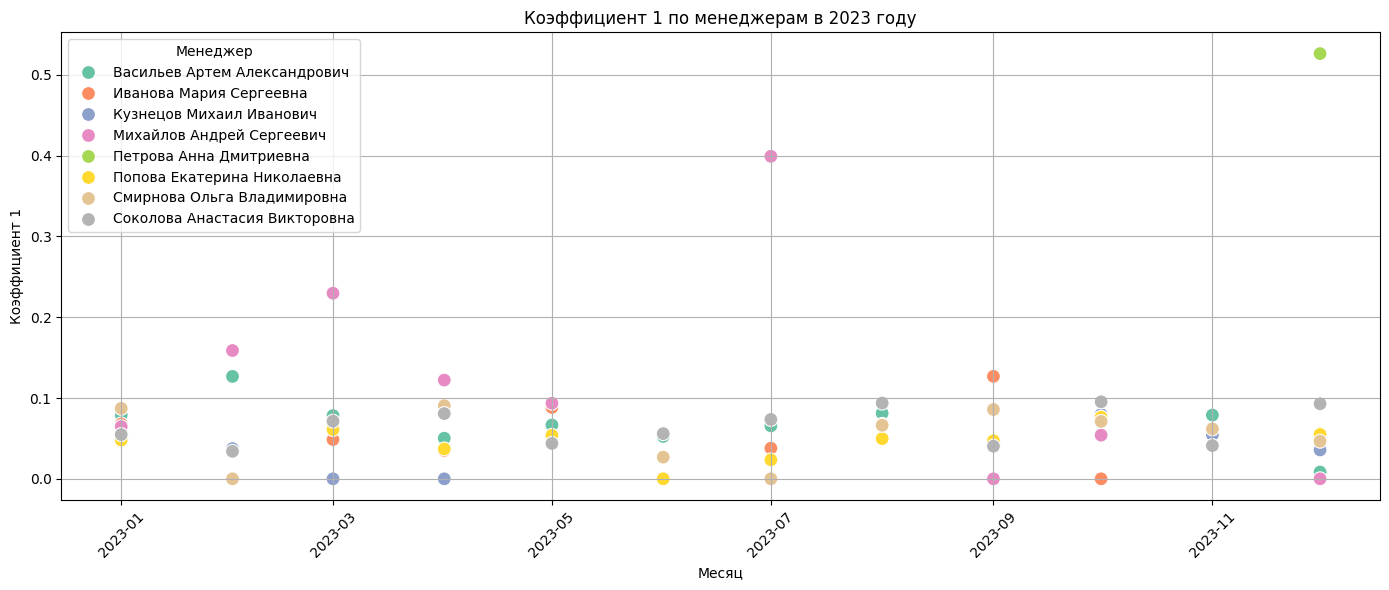

In [ ]:
final_result["Месяц_дата"] = pd.to_datetime(final_result["Месяц"], format="%Y-%m")
final_result = final_result[final_result["Месяц_дата"].dt.year == 2023]
plot_data = final_result.dropna(subset=["Коэффициент 1"])

plt.figure(figsize=(14, 6))

sns.scatterplot(
    data=plot_data,
    x="Месяц_дата",
    y="Коэффициент 1",
    hue="Менеджер",
    palette="Set2",
    s=100,
    legend=True  
)

plt.title("Коэффициент 1 по менеджерам в 2023 году")
plt.xlabel("Месяц")
plt.ylabel("Коэффициент 1")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


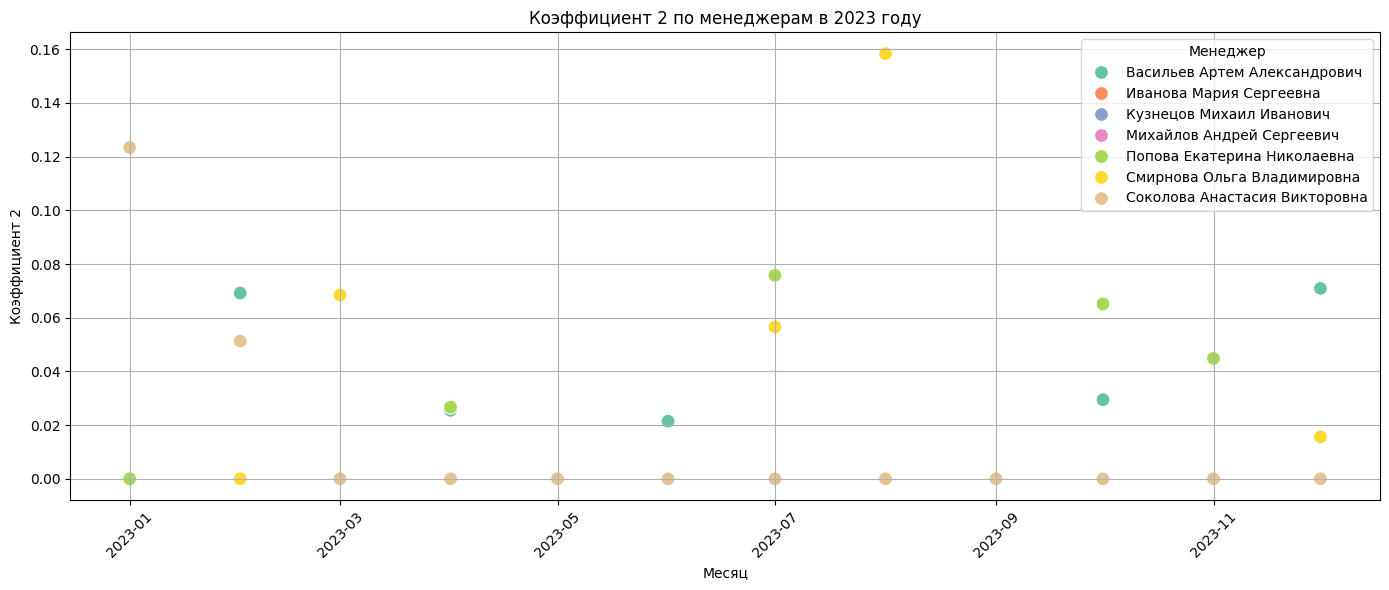

In [ ]:
plot_data_2 = final_result.dropna(subset=["Коэффициент 2"])

plt.figure(figsize=(14, 6))

sns.scatterplot(
    data=plot_data_2,
    x="Месяц_дата",
    y="Коэффициент 2",
    hue="Менеджер",
    palette="Set2",
    s=100,
    legend=True  # Показываем легенду для менеджеров
)

plt.title("Коэффициент 2 по менеджерам в 2023 году")
plt.xlabel("Месяц")
plt.ylabel("Коэффициент 2")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()